Вот скрипт, который загружает обученную модель, применяет её к тому же датафрейму и добавляет новую колонку с прогнозами (PREDICTION).

Что делает этот скрипт:  
Загружает данные из базы, как и в обучающем скрипте.  
Кодирует свечи (используется тот же алгоритм CANDLE_CODE).  
Преобразует коды свечей в числовые метки (CANDLE_INT).  
Определяет структуру нейросети, чтобы она совпадала с обученной.  
Загружает веса модели из best_model_02.pth.  
Прогнозирует движение цены (1 – рост, 0 – падение).  
Добавляет колонку PREDICTION в датафрейм.  
Сохраняет результат в predictions.csv.  
Теперь в файле predictions.csv у вас будет таблица с прогнозами. 🚀  

In [15]:
import sqlite3
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path

# === 1. ЗАГРУЗКА ДАННЫХ ===
db_path = Path(r'C:\Users\Alkor\gd\data_quote_db\RTS_futures_options_day.db')

with sqlite3.connect(db_path) as conn:
    df_fut = pd.read_sql_query(
        "SELECT TRADEDATE, OPEN, LOW, HIGH, CLOSE, VOLUME FROM Futures",
        conn
    )

# === 2. ФУНКЦИЯ КОДИРОВАНИЯ СВЕЧЕЙ (ЛИХОВИДОВ) ===
def encode_candle(row):
    open_, low, high, close = row['OPEN'], row['LOW'], row['HIGH'], row['CLOSE']

    direction = 1 if close > open_ else (0 if close < open_ else 2)
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    body = abs(close - open_)

    def classify_shadow(shadow, body):
        return 0 if shadow < 0.1 * body else (1 if shadow < 0.5 * body else 2)

    return f"{direction}{classify_shadow(upper_shadow, body)}{classify_shadow(lower_shadow, body)}"

df_fut['CANDLE_CODE'] = df_fut.apply(encode_candle, axis=1)

# === 3. ПРЕОБРАЗОВАНИЕ КОДОВ В ЧИСЛА ===
unique_codes = sorted(df_fut['CANDLE_CODE'].unique())
code_to_int = {code: i for i, code in enumerate(unique_codes)}
df_fut['CANDLE_INT'] = df_fut['CANDLE_CODE'].map(code_to_int)

window_size = 20  

# === 4. ОПРЕДЕЛЕНИЕ МОДЕЛИ (ДОЛЖНА СОВПАДАТЬ С ОБУЧЕННОЙ) ===
class CandleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CandleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return self.sigmoid(x)

# === 5. ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "bm_fut_lih_02.pth"
model = CandleLSTM(
    vocab_size=len(unique_codes), embedding_dim=8, hidden_dim=32, output_dim=1
    ).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === 6. ПРОГНОЗИРОВАНИЕ ===
predictions = []
with torch.no_grad():
    for i in range(len(df_fut) - window_size):
        sequence = torch.tensor(
            df_fut['CANDLE_INT'].iloc[i:i+window_size].values, dtype=torch.long
            ).unsqueeze(0).to(device)
        pred = model(sequence).item()
        predictions.append(1 if pred > 0.5 else 0)

# Заполняем колонку PREDICTION (первые window_size значений - NaN)
df_fut['PREDICTION'] = [None] * window_size + predictions

# === 7. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
df_fut.to_csv("predictions_fut_lih_02.csv", index=False)
print("✅ Прогнозы сохранены в 'predictions_fut_lih_02'")


✅ Прогнозы сохранены в 'predictions_fut_lih_02'


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === 1. ЗАГРУЗКА РЕЗУЛЬТАТОВ ===
df_fut = pd.read_csv("predictions_fut_lih_02.csv")

# === 2. ДОБАВЛЯЕМ ФАКТИЧЕСКИЙ НАПРАВЛЕНИЕ ЦЕНЫ ===
df_fut['ACTUAL'] = (df_fut['CLOSE'].diff() > 0).astype(int)

# Убираем первые `window_size` значений, где нет прогноза
df_fut = df_fut.dropna(subset=['PREDICTION'])

# Преобразуем в int
df_fut['PREDICTION'] = df_fut['PREDICTION'].astype(int)

# === 3. ОЦЕНКА ТОЧНОСТИ ===
accuracy = accuracy_score(df_fut['ACTUAL'], df_fut['PREDICTION'])
print(f"✅ Точность модели: {accuracy:.2%}")

# === 4. ВЫВОД МАТРИЦЫ ОШИБОК ===
conf_matrix = confusion_matrix(df_fut['ACTUAL'], df_fut['PREDICTION'])
print("\n📊 Матрица ошибок:\n", conf_matrix)

# === 5. ПОДРОБНЫЙ ОТЧЁТ ПО КЛАССАМ ===
report = classification_report(
    df_fut['ACTUAL'], df_fut['PREDICTION'], target_names=["⬇ Падение", "⬆ Рост"]
    )
print("\n📋 Отчет о качестве предсказаний:\n", report)

✅ Точность модели: 50.67%

📊 Матрица ошибок:
 [[564 638]
 [606 714]]

📋 Отчет о качестве предсказаний:
               precision    recall  f1-score   support

   ⬇ Падение       0.48      0.47      0.48      1202
      ⬆ Рост       0.53      0.54      0.53      1320

    accuracy                           0.51      2522
   macro avg       0.51      0.51      0.50      2522
weighted avg       0.51      0.51      0.51      2522



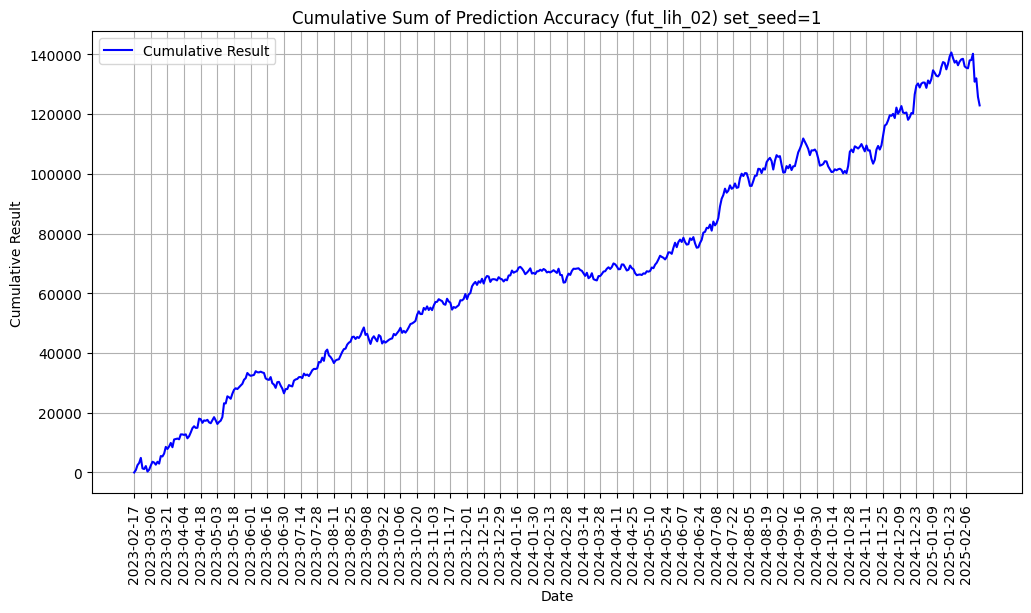

In [ ]:
'''
Здесь используется смещение колонки прогноза для сравнения прогноза и факта.
'''
import pandas as pd
import matplotlib.pyplot as plt

# === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
df = pd.read_csv("predictions_fut_lih_02.csv")

split = int(len(df) * 0.8)  # 80% - обучающая выборка, 20% - тестовая
df = df.iloc[split:].copy()  # Берем последние 20%

# === 2. СМЕЩЕНИЕ ПРОГНОЗА НА ОДИН БАР ВПЕРЁД ===
df["PREDICTION_SHIFTED"] = df["PREDICTION"].shift(1)  # Смещаем вверх

# df

# === 3. РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION_SHIFTED"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0

    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction = row["PREDICTION_SHIFTED"]

    difference = abs(row["CLOSE"] - row["OPEN"])
    return difference if true_direction == predicted_direction else -difference

df["RESULT"] = df.apply(calculate_result, axis=1)

# === 4. ПОСТРОЕНИЕ КУМУЛЯТИВНОГО ГРАФИКА ===
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result", color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title("Cumulative Sum of Prediction Accuracy (fut_lih_02) set_seed=")
plt.legend()
plt.grid()

# plt.xticks(rotation=45)
plt.xticks(df["TRADEDATE"][::10], rotation=90)
plt.show()

In [19]:
df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION,PREDICTION_SHIFTED,RESULT,CUMULATIVE_RESULT
2033,2023-02-17,92180.0,91400.0,93950.0,93900.0,110862,101,10,0.0,NaN,0.0,0.0
2034,2023-02-20,93910.0,92090.0,94430.0,93100.0,112233,22,8,1.0,0.0,810.0,810.0
2035,2023-02-21,93200.0,92650.0,95940.0,94850.0,143567,121,16,0.0,1.0,1650.0,2460.0
2036,2023-02-22,94650.0,93150.0,95200.0,93910.0,86329,22,8,0.0,0.0,740.0,3200.0
2037,2023-02-24,93990.0,92000.0,94890.0,92310.0,96469,21,7,0.0,0.0,1680.0,4880.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2537,2025-02-12,98600.0,98120.0,101480.0,100700.0,124069,111,13,0.0,1.0,2100.0,140200.0
2538,2025-02-13,100570.0,100080.0,111010.0,109930.0,247083,110,12,0.0,0.0,-9360.0,130840.0
2539,2025-02-14,109750.0,106470.0,114130.0,108620.0,282242,22,8,0.0,0.0,1130.0,131970.0
2540,2025-02-17,108960.0,108050.0,115370.0,115170.0,183356,101,10,1.0,0.0,-6210.0,125760.0


# Мартингейл

Что делает этот код?
Добавляет колонку WIN

1, если прогноз верный (направление движения совпало).
0, если прогноз ошибочный.
Определяет последовательности (STREAK)

Группирует одинаковые значения WIN подряд.
Подсчитывает длину последовательностей

Выводит статистику по сериям побед и поражений.
Сохраняет обновленный файл

В predictions_with_win.csv добавлена информация о выигрышах и сериях.
Теперь можно анализировать вероятность длинных серий проигрышей и тестировать стратегию Мартингейла. 🚀

In [20]:
# === 1. ЗАГРУЗКА ФАЙЛА И ОТБОР ПОСЛЕДНИХ 20% ===
df = pd.read_csv("predictions_fut_lih_02.csv")

split = int(len(df) * 0.8)  # 80% - обучающая выборка, 20% - тестовая
df = df.iloc[split:].copy()  # Берем последние 20%

# === 2. СМЕЩЕНИЕ ПРОГНОЗА НА 1 БАР ===
df["PREDICTION_SHIFTED"] = df["PREDICTION"].shift(1)

# === 3. СОЗДАНИЕ КОЛОНКИ "WIN" (1 - если прогноз верный, 0 - если нет) ===
df["WIN"] = (df["PREDICTION_SHIFTED"] == (df["CLOSE"] > df["OPEN"])).astype(int)

# === 4. ПОДСЧЁТ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ВЫИГРЫШЕЙ / ПРОИГРЫШЕЙ ===
df["STREAK"] = df["WIN"] * (df["WIN"] != df["WIN"].shift()).cumsum()

# === 5. ГРУППИРОВКА ПОСЛЕДОВАТЕЛЬНОСТЕЙ ===
streak_counts = df.groupby("STREAK")["WIN"].count().reset_index()
streak_counts.columns = ["Streak ID", "Length"]
streak_counts = streak_counts[streak_counts["Streak ID"] != 0]  # Убираем пустые строки

# === 6. ВЫВОД СТАТИСТИКИ ===
print(streak_counts.describe())

# === 7. СОХРАНЕНИЕ ОБНОВЛЕННОГО ФАЙЛА ===
df.to_csv("predictions_fut_lih_with_win_02.csv", index=False)
print("✅ Файл с последовательностями сохранён в 'predictions_fut_lih_with_win_02.csv'")

        Streak ID      Length
count  130.000000  130.000000
mean   131.000000    2.269231
std     75.343657    1.697186
min      2.000000    1.000000
25%     66.500000    1.000000
50%    131.000000    2.000000
75%    195.500000    3.000000
max    260.000000   12.000000
✅ Файл с последовательностями сохранён в 'predictions_fut_lih_with_win_02.csv'


Что делает этот код?  
Функция count_streaks  

Использует groupby, чтобы найти последовательности 0 и 1.  
Подсчитывает их длину и количество.  
Создаёт два словаря  

zero_streaks — статистика серий 0.  
one_streaks — статистика серий 1.  
Выводит данные в удобном формате  

In [21]:
import pandas as pd
from itertools import groupby

# === 1. ЗАГРУЗКА ФАЙЛА ===
df = pd.read_csv("predictions_fut_lih_with_win_02.csv")

# === 2. ПОДСЧЁТ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ===
def count_streaks(sequence, value):
    """Функция для подсчёта серий заданного значения (0 или 1)"""
    streaks = [len(list(group)) for key, group in groupby(sequence) if key == value]
    streak_counts = {i: streaks.count(i) for i in set(streaks)}
    return streak_counts

# Создаём словари с количеством серий для 0 и 1
zero_streaks = count_streaks(df["WIN"], 0)
one_streaks = count_streaks(df["WIN"], 1)

# === 3. ВЫВОД СТАТИСТИКИ ===
print("📊 Статистика серий для 0:")
for length in sorted(zero_streaks.keys()):
    print(f"{length} ноль подряд — {zero_streaks[length]} раз(а)")

print("\n📊 Статистика серий для 1:")
for length in sorted(one_streaks.keys()):
    print(f"{length} единица подряд — {one_streaks[length]} раз(а)")

📊 Статистика серий для 0:
1 ноль подряд — 78 раз(а)
2 ноль подряд — 32 раз(а)
3 ноль подряд — 13 раз(а)
4 ноль подряд — 7 раз(а)
5 ноль подряд — 1 раз(а)

📊 Статистика серий для 1:
1 единица подряд — 53 раз(а)
2 единица подряд — 36 раз(а)
3 единица подряд — 23 раз(а)
4 единица подряд — 7 раз(а)
5 единица подряд — 3 раз(а)
6 единица подряд — 4 раз(а)
7 единица подряд — 2 раз(а)
8 единица подряд — 1 раз(а)
12 единица подряд — 1 раз(а)
